In [2]:
!chcp 65001

Active code page: 65001


In [1]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2 Dataset images'
for root, dirs, files in os.walk(root):
    if root.endswith('_Dermoscopic_Image'):
        for file in files:  # Загружаем все файлы, а не только первый
            images.append(imread(os.path.join(root, file)))

    if root.endswith('_lesion'):
        for file in files:
            lesions.append(imread(os.path.join(root, file)))

In [4]:
len(images)

200

In [2]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]
len(images)

200

In [3]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


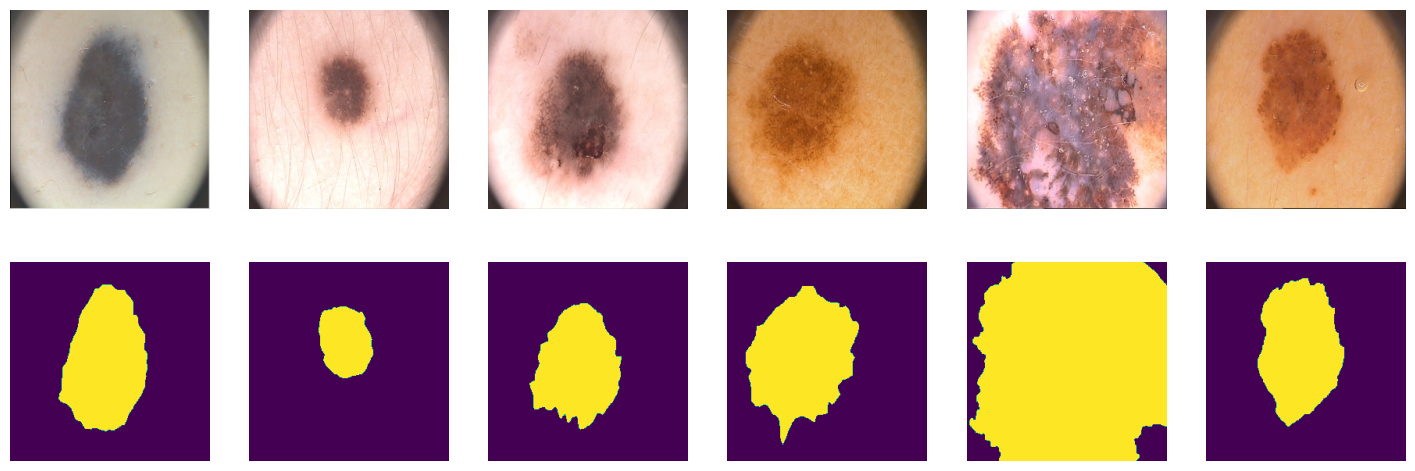

In [4]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

n_imgs = np.random.randint(0, len(X), size=6)
plt.figure(figsize=(18, 6))
for i in range(len(n_imgs)):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[n_imgs[i]])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[n_imgs[i]])
plt.show();

In [6]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [9]:
print(len(tr), len(val), len(ts))

100 50 50


In [10]:
Y[tr, np.newaxis].shape

(100, 1, 256, 256)

In [7]:
from torch.utils.data import DataLoader
batch_size = 25
train_dataloader = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                     batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [8]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [13]:
!pip install torchmetrics

In [14]:
from torchmetrics import JaccardIndex

iou_score = JaccardIndex(threshold=0.5, task="binary", average='none').to(device)

In [9]:
import torch.nn.functional as F
import torch.nn as nn
import numpy as np

## SegNet

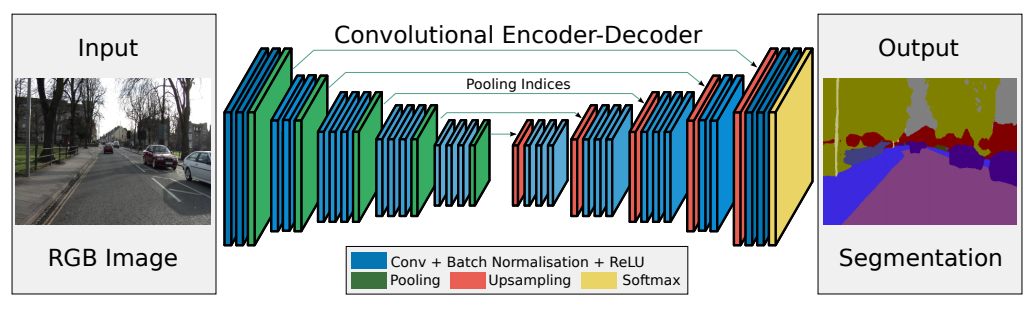


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim

In [11]:
class SegNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super().__init__()

        # VGG-16 architecture

        self.enc1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            # nn.ReLU(inplace=True),
            nn.LeakyReLU(0.1),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            # nn.ReLU(inplace=True),
            nn.LeakyReLU(0.1),

              )
        self.p1 = nn.MaxPool2d(2, 2, return_indices=True)

        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            # nn.ReLU(inplace=True),
            nn.LeakyReLU(0.1),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            # nn.ReLU(inplace=True),
            nn.LeakyReLU(0.1),
              )

        self.p2 = nn.MaxPool2d(2, 2, return_indices=True)


        self.enc3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            # nn.ReLU(inplace=True),
            nn.LeakyReLU(0.1),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            # nn.ReLU(inplace=True),
            nn.LeakyReLU(0.1),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            # nn.ReLU(inplace=True),
            nn.LeakyReLU(0.1),
              )

        self.p3 = nn.MaxPool2d(2, 2, return_indices=True)

        self.enc4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            # nn.ReLU(inplace=True),
            nn.LeakyReLU(0.1),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            # nn.ReLU(inplace=True),
            nn.LeakyReLU(0.1),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
           # nn.ReLU(inplace=True),
            nn.LeakyReLU(0.1),
              )
        self.p4 = nn.MaxPool2d(2, 2, return_indices=True)


        # bottleneck
        self.bottle_neck_enc = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            # nn.ReLU(inplace=True),
            nn.LeakyReLU(0.1),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            # nn.ReLU(inplace=True),
            nn.LeakyReLU(0.1),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            # nn.ReLU(inplace=True),
            nn.LeakyReLU(0.1),
        )
        self.bp = nn.MaxPool2d(2, 2, return_indices=True)

        self.bottle_neck_dec = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            # nn.ReLU(inplace=True),
            nn.LeakyReLU(0.1),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            # nn.ReLU(inplace=True),
            nn.LeakyReLU(0.1),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            # nn.ReLU(inplace=True),
            nn.LeakyReLU(0.1),

        )

        self.bup = nn.MaxUnpool2d(2, 2)

        # decoder (upsampling)

        self.dec1 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            # nn.ReLU(inplace=True),
            nn.LeakyReLU(0.1),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            # nn.ReLU(inplace=True),
            nn.LeakyReLU(0.1),
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            # nn.ReLU(inplace=True),
            nn.LeakyReLU(0.1),

        )
        self.up1 = nn.MaxUnpool2d(2, 2)


        self.dec2 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            # nn.ReLU(inplace=True),
            nn.LeakyReLU(0.1),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            # nn.ReLU(inplace=True),
            nn.LeakyReLU(0.1),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            # nn.ReLU(inplace=True),
            nn.LeakyReLU(0.1),

        )
        self.up2 = nn.MaxUnpool2d(2, 2)

        self.dec3 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            # nn.ReLU(inplace=True),
            nn.LeakyReLU(0.1),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            # nn.ReLU(inplace=True),
            nn.LeakyReLU(0.1),

        )
        self.up3 = nn.MaxUnpool2d(2, 2)

        self.dec4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            # nn.ReLU(inplace=True),
            nn.LeakyReLU(0.1),
            nn.Conv2d(64, 1, kernel_size=3, padding=1),
        )
        self.up4 = nn.MaxUnpool2d(2, 2)


    def forward(self, x):
        # encoder
        enc1 = self.enc1(x)
        enc1_p, ind1 = self.p1(enc1)

        enc2 = self.enc2(enc1_p)
        enc2_p, ind2 = self.p2(enc2)

        enc3 = self.enc3(enc2_p)
        enc3_p, ind3 = self.p3(enc3)

        enc4 = self.enc4(enc3_p)
        enc4_p, ind4 = self.p4(enc4)

        # bottleneck
        encb = self.bottle_neck_enc(enc4_p)
        encb_p, indb = self.bp(encb)

        decb = self.bup(encb_p, indb)
        decb = self.bottle_neck_dec(decb)

        # decoder
        dec1 = self.up1(decb, ind4)
        dec1 = self.dec1(dec1)

        dec2 = self.up2(dec1, ind3)
        dec2 = self.dec2(dec2)

        dec3 = self.up3(dec2, ind2)
        dec3 = self.dec3(dec3)

        dec4 = self.up4(dec3, ind1)
        output = self.dec4(dec4)
        return output # no activation

In [12]:
from tqdm.notebook import tqdm
from torchmetrics.classification import BinaryJaccardIndex
from IPython.display import clear_output

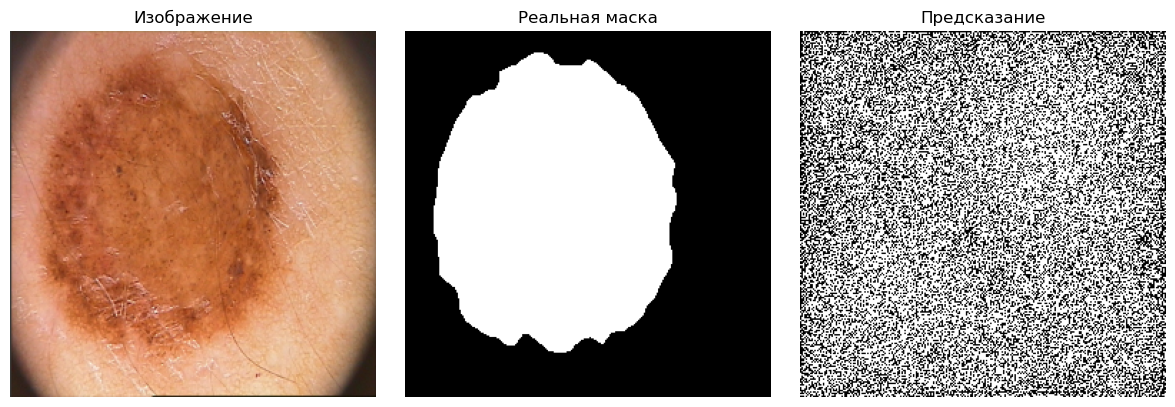

In [18]:
def visualize_predictions(image, mask, pred):
    clear_output(wait=True)
    plt.close('all')

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    image_np = image.numpy()
    if image_np.shape[0] == 3:  # [C, H, W] -> [H, W, C]
        image_np = np.moveaxis(image_np, 0, -1)

    axes[0].imshow(image_np)
    axes[0].set_title('Изображение')
    axes[0].axis('off')

    axes[1].imshow(mask.numpy().squeeze(), cmap='gray')
    axes[1].set_title('Реальная маска')
    axes[1].axis('off')

    axes[2].imshow(pred.numpy().squeeze(), cmap='gray')
    axes[2].set_title('Предсказание')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

batch = next(iter(valid_dataloader))
images, masks = batch  # Распаковка батча
images, masks = images.cpu(), masks.cpu()

segnet_model = SegNet().to(device)
idx = torch.randint(0, images.shape[0], (1,)).item()
image, mask = images[idx], masks[idx]


pred = segnet_model(image.unsqueeze(0).to(device)).detach().cpu().squeeze(0)
pred = torch.sigmoid(pred) > 0.5  # Бинаризация


visualize_predictions(image, mask, pred)

In [13]:
def init_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_uniform_(m.weight)

In [14]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super().__init__()
        self.smooth = smooth

    def forward(self, pred, target):
        pred = torch.sigmoid(pred)  
        pred_flat = pred.view(-1)
        target_flat = target.view(-1)
        intersection = (pred_flat * target_flat).sum()
        dice = (2. * intersection + self.smooth) / (pred_flat.sum() + target_flat.sum() + self.smooth)
        return 1 - dice


Epoch [1/20], Loss: 2.1691


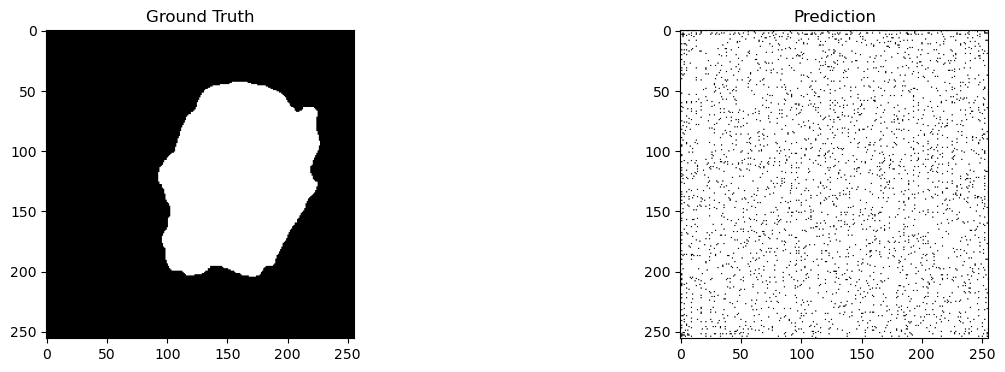

Epoch [2/20], Loss: 1.6614


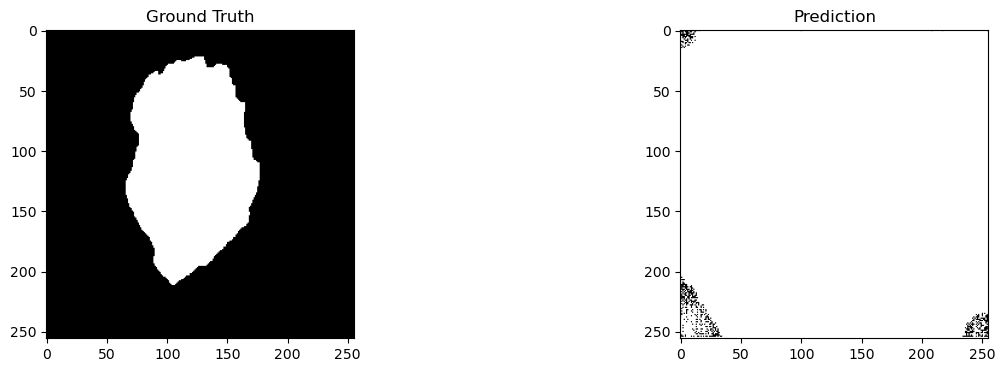

Epoch [3/20], Loss: 1.2882


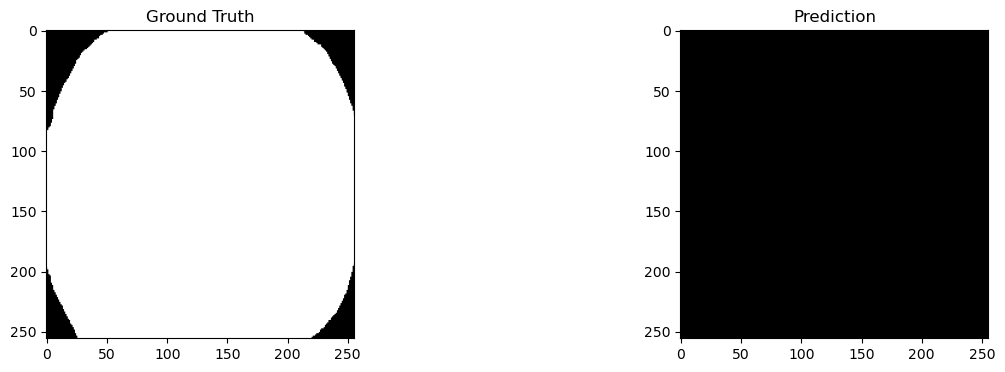

Epoch [4/20], Loss: 1.0860


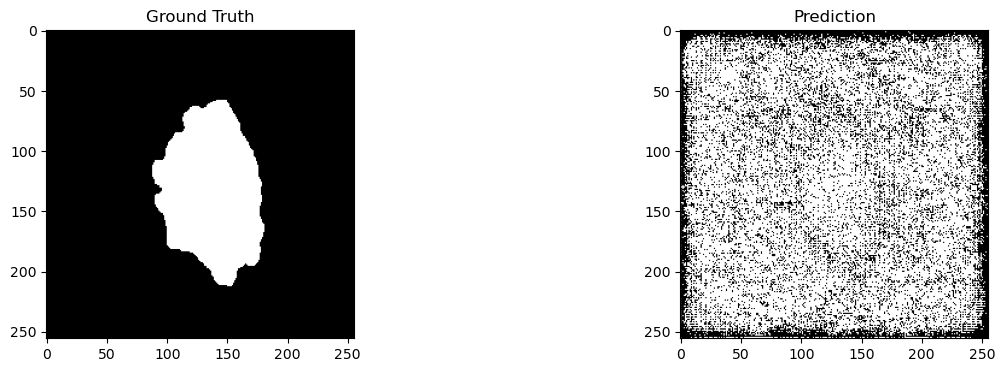

Epoch [5/20], Loss: 1.1088


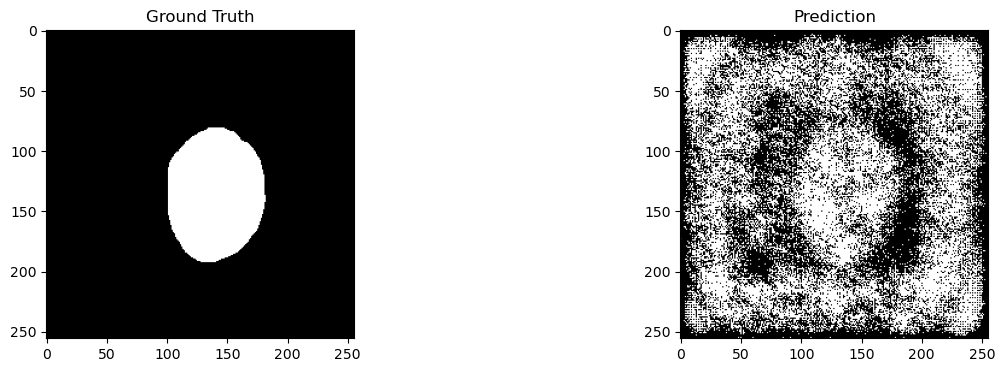

Epoch [6/20], Loss: 0.9776


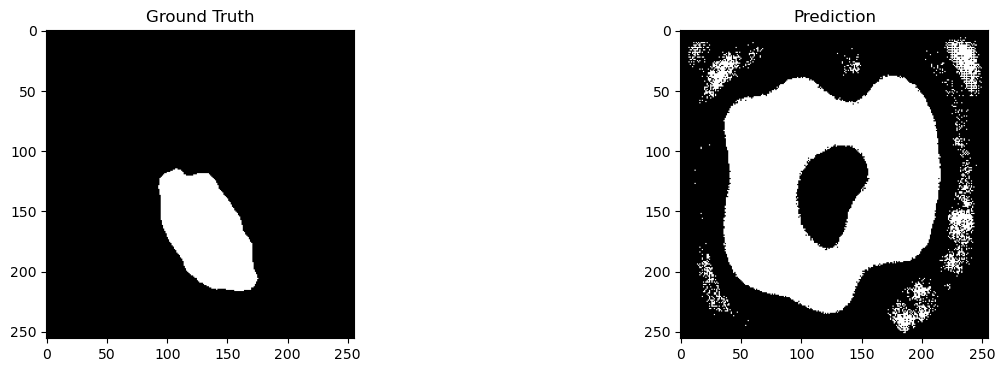

Epoch [7/20], Loss: 0.8332


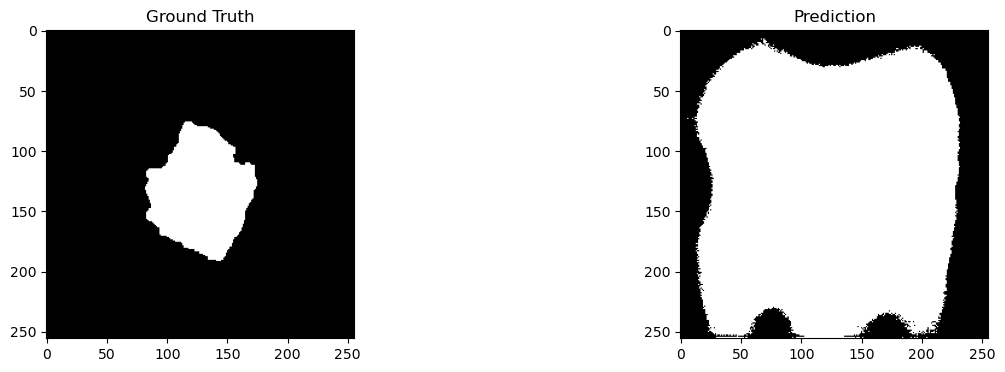

Epoch [8/20], Loss: 0.8328


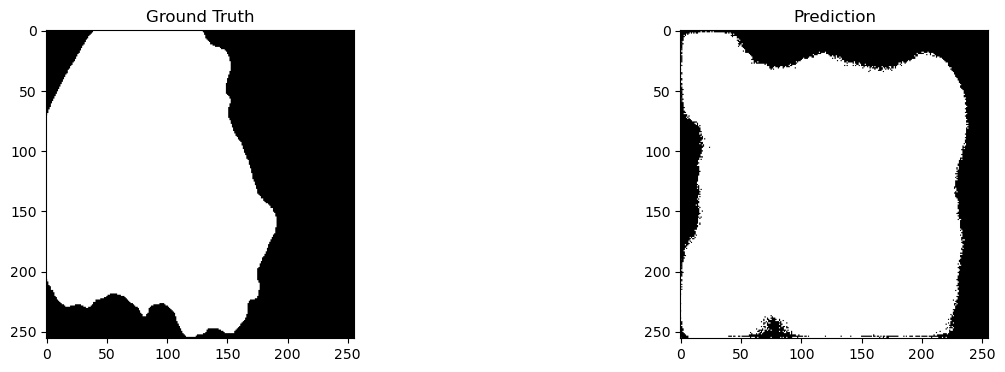

Epoch [9/20], Loss: 0.7042


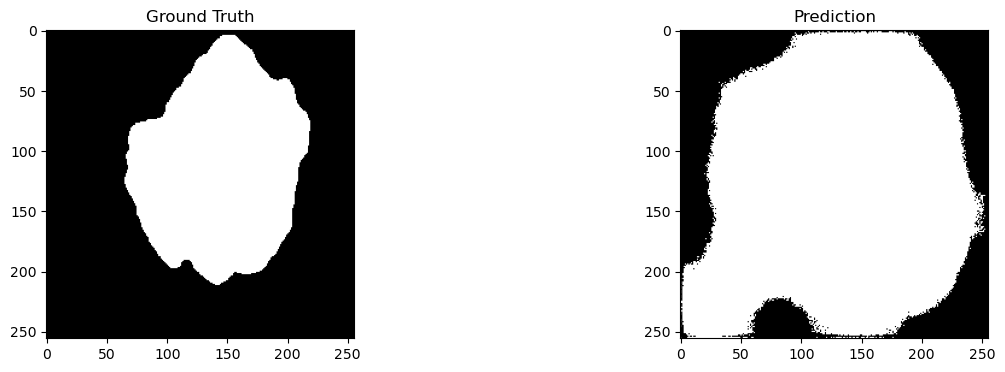

Epoch [10/20], Loss: 0.6215


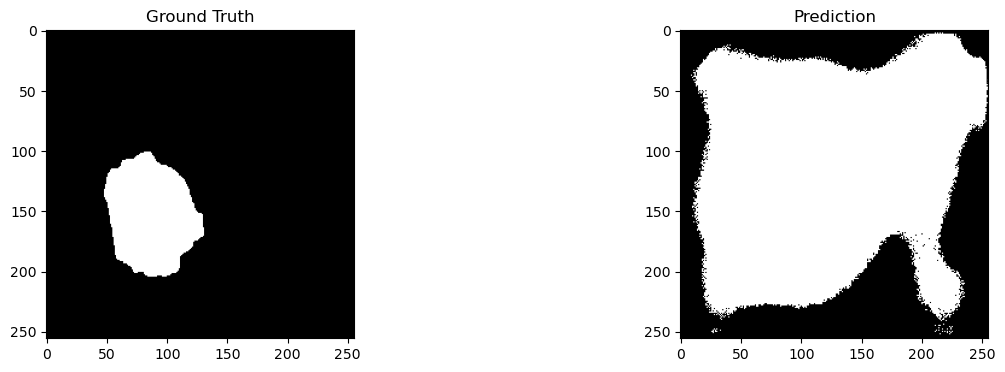

Epoch [11/20], Loss: 0.7481


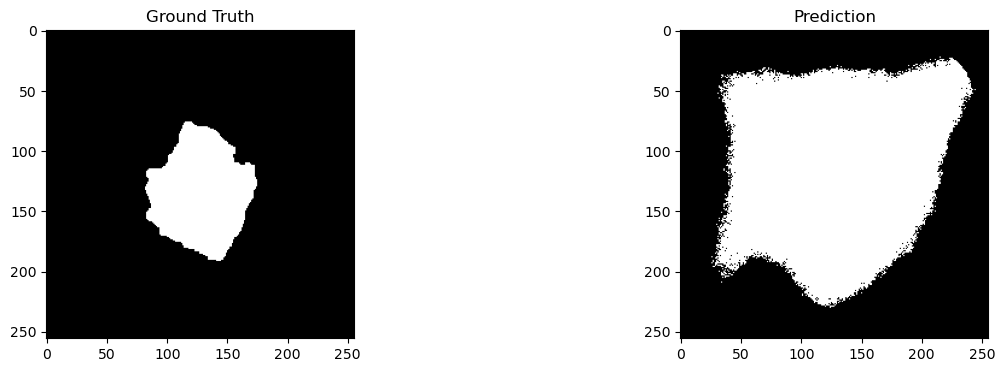

Epoch [12/20], Loss: 0.6795


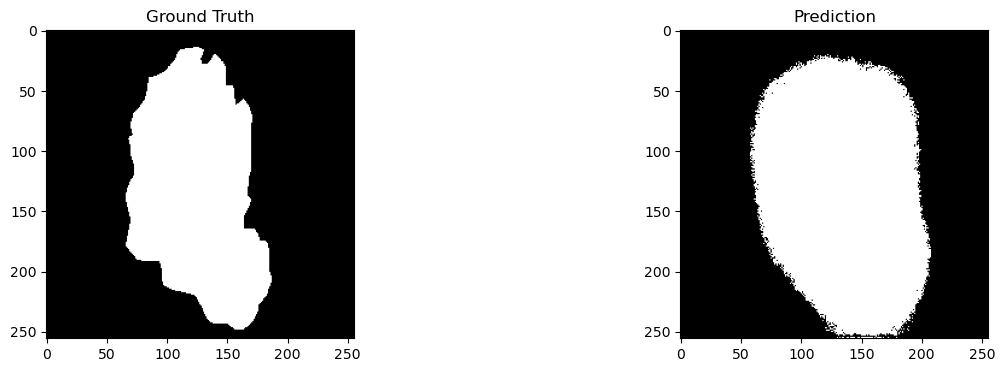

Epoch [13/20], Loss: 0.6237


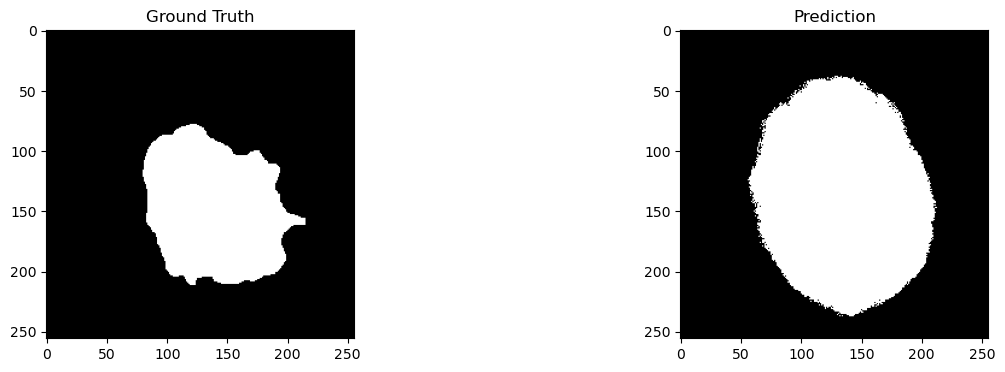

Epoch [14/20], Loss: 0.5780


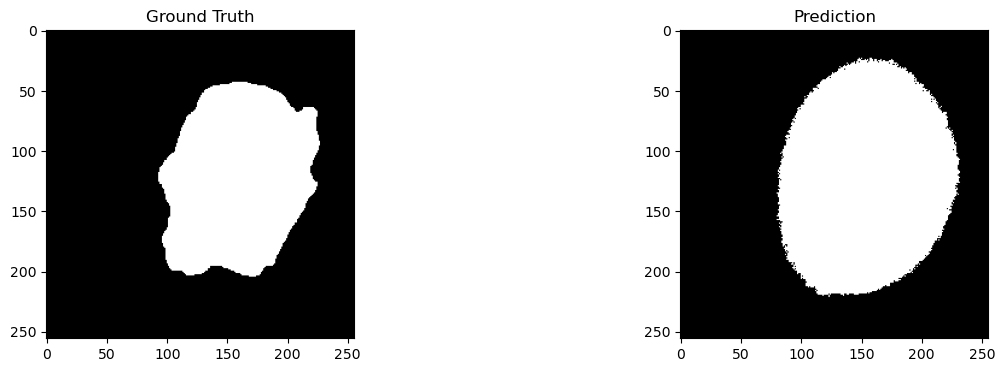

Epoch [15/20], Loss: 0.5901


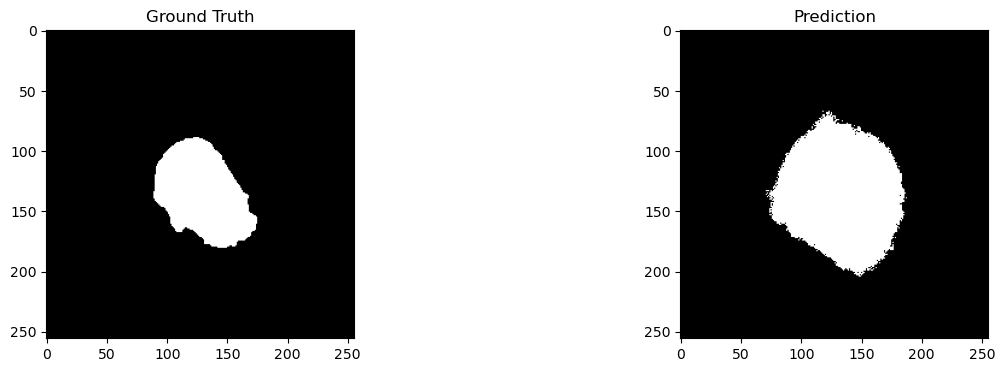

Epoch [16/20], Loss: 0.6092


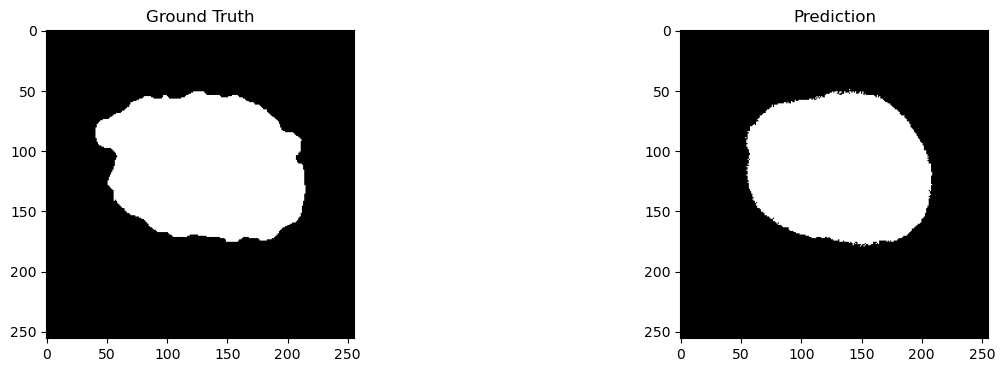

Epoch [17/20], Loss: 0.6988


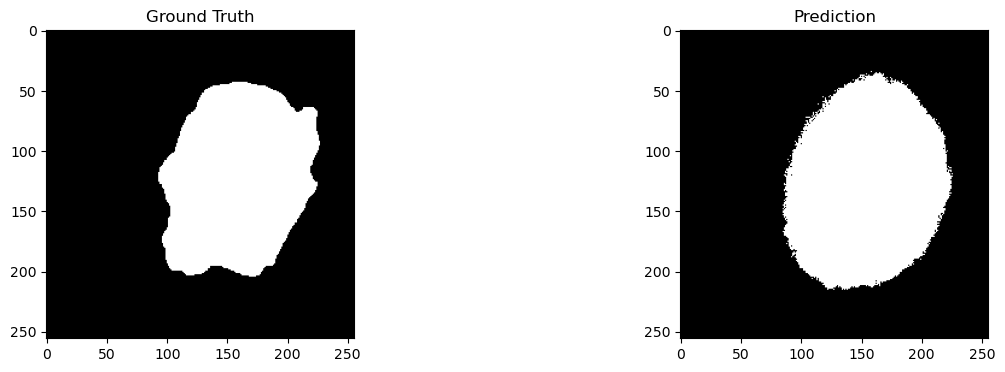

Epoch [18/20], Loss: 0.5563


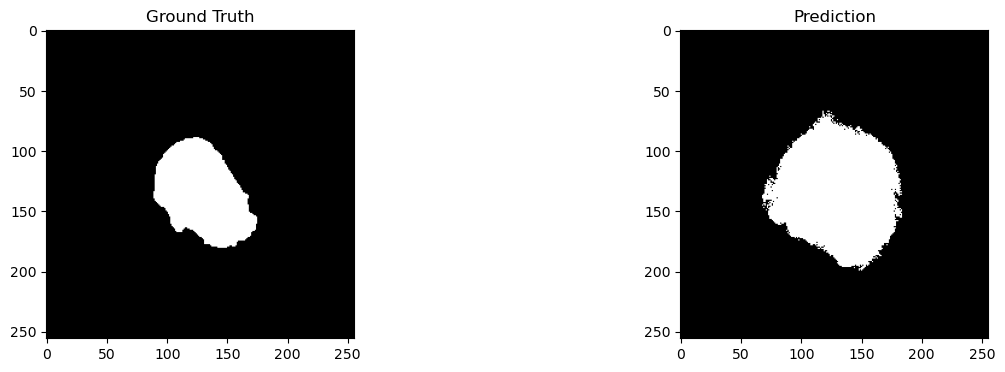

Epoch [19/20], Loss: 0.5818


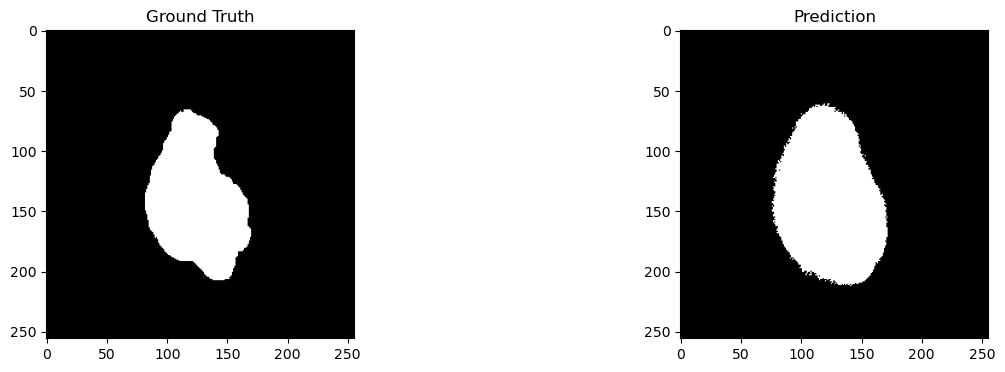

Epoch [20/20], Loss: 0.5760


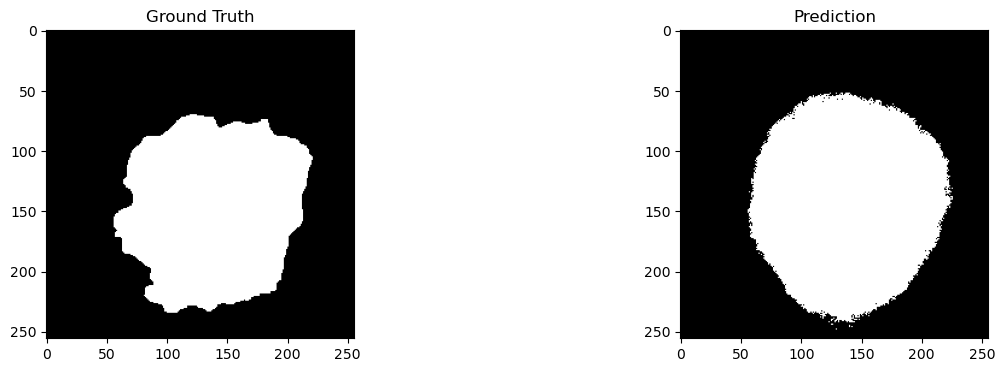

In [23]:
segnet_model = SegNet().to(device)
segnet_model.apply(init_weights)
criterion = lambda pred, target: DiceLoss()(pred, target) + nn.BCEWithLogitsLoss(pos_weight=torch.tensor([5.0]).to(pred.device))(pred, target)

optimizer = torch.optim.Adam(segnet_model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# losses = train(segnet_model, train_dataloader, valid_dataloader, num_epochs, criterion, optimizer, batch_size, scheduler)
def validate_and_show(model, dataloader):
    model.eval()
    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()

            plt.subplot(1, 2, 1)
            plt.imshow(masks[0][0].cpu(), cmap='gray')
            plt.title("Ground Truth")

            plt.subplot(1, 2, 2)
            plt.imshow(preds[0][0].cpu(), cmap='gray')
            plt.title("Prediction")

            plt.show()
            break

num_epochs = 20
train_losses = []

for epoch in range(num_epochs):
    segnet_model.train()
    epoch_loss = 0

    for images, masks in train_dataloader:
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = segnet_model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    scheduler.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / len(train_dataloader):.4f}")
    train_losses.append(epoch_loss / len(train_dataloader))

    # проверить как работает предсказание после каждой эпохи
    validate_and_show(segnet_model, valid_dataloader)

In [25]:
torch.save(segnet_model.state_dict(), 'seg_net_weights.pth')

print("Веса модели успешно сохранены")

Веса модели успешно сохранены


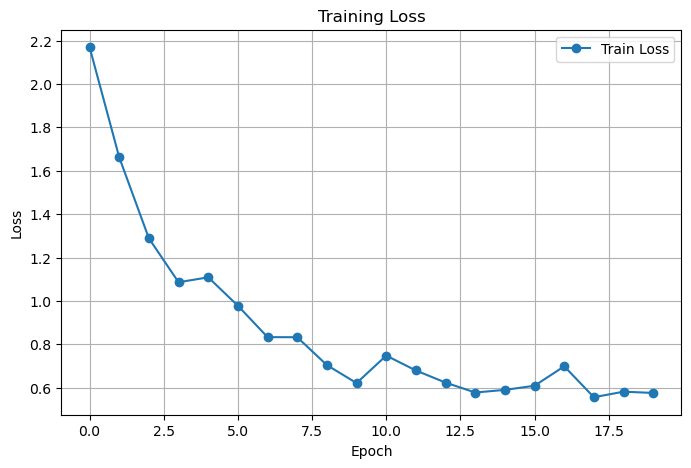

In [33]:
import matplotlib.pyplot as plt


plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid(True)
plt.show()


In [15]:
model_with_load = SegNet().to(device) 
model_with_load.load_state_dict(torch.load('seg_net_weights.pth'))

<All keys matched successfully>

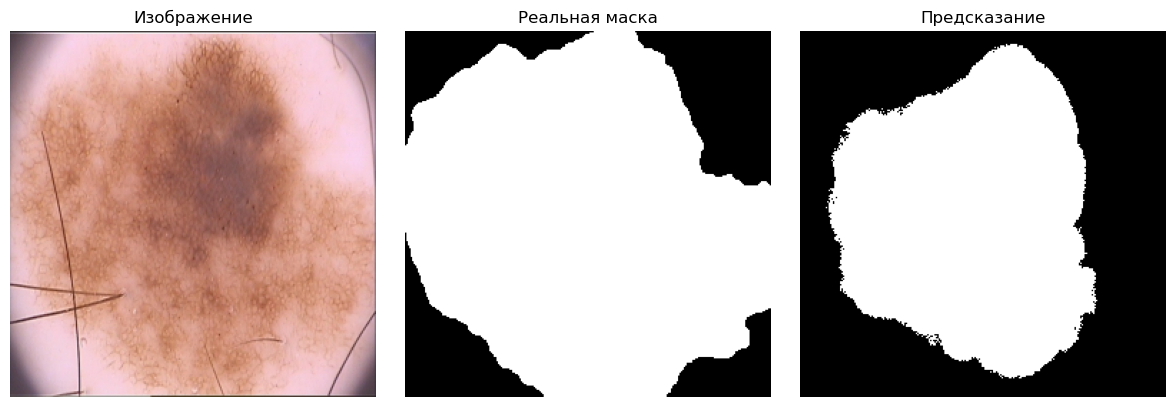

In [23]:
batch = next(iter(valid_dataloader))
images, masks = batch 
images, masks = images.cpu(), masks.cpu()

# segnet_model = SegNet().to(device)
idx = torch.randint(0, images.shape[0], (1,)).item()
image, mask = images[idx], masks[idx]


pred = model_with_load(image.unsqueeze(0).to(device)).detach().cpu().squeeze(0)
pred = torch.sigmoid(pred) > 0.5  

visualize_predictions(image, mask, pred)